# Raman Spectroscopy Generative Adversarial Network

## Import libraries and read data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl   
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LeakyReLU
from keras.utils import to_categorical
import glob

2023-11-12 15:17:46.673629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 15:17:46.704184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 15:17:46.704780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 15:17:47.204036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mpl.rc('figure.subplot', left=.2, right=.8, bottom=.2, top=.8)
width, height = 20, 6
mpl.rcParams['figure.figsize'] = [width, height]
# custom_colors = plt.rcParams['axes.prop_cycle']() 

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
custom_xticks = [0] + [i for i in range(350, 1651, 50)]
custom_xlim = (0, 1331)

sns.set_context("paper", rc={"lines.linewidth": 1})
sns.set_style('whitegrid')

In [3]:
data = pd.read_csv("../input/data.csv")

### txt to csv

In [ ]:
def txt2csv(directory_path, diagnostic, format='v1'):
    txt_files = glob.glob(directory_path + '/*.txt')
    column_names = ['Wavelength', 'Intensity']
    samples = []
    for file in txt_files:
        if format == 'v1':
            df = pd.read_csv(file, skiprows=4, names=column_names)[:-1]
        elif format == 'v2':
            df = pd.read_csv(file, skiprows=1, names=column_names)
        df = df.pivot_table(index=None, values='Intensity', columns='Wavelength', sort=False)
        df['Diagnostic'] = diagnostic
        samples.append(df)
    return pd.concat(samples, ignore_index=True)

In [ ]:
# tmp_df = txt2csv('../input/raw/blank-negative', diagnostic='Blank', format='v1')

In [ ]:
# tmp_df.columns = tmp_df.columns.astype(str)

In [ ]:
# data = pd.concat([data, tmp_df], ignore_index=True)

In [ ]:
# data['COVID-19_Status'] = np.where(data['Diagnostic'].isin(['Blank', 'Streptavidin']), 'negative', 'positive')

In [4]:
display(data.head().T)

,0,1,2,3,4
320,-1.388896,16.722093,0.329687,-10.598846,10.015236
321,0.05821,-1.186429,-0.747993,-5.978379,12.575455
322,5.898464,-10.186022,-1.588051,1.822014,13.012607
323,5.849397,-3.832706,0.152671,12.90642,13.932454
324,2.37903,12.73007,5.357345,21.049637,13.677982
...,...,...,...,...,...
1648,1.384356,-4.633642,-5.380405,10.001486,35.561525
1649,16.59277,-6.431111,-6.852814,1.22302,37.348663
1650,8.760738,25.847542,-2.682321,1.914469,11.53166
Diagnostic,Streptavidin,Streptavidin,Streptavidin,S,S


In [ ]:
print(data.shape)

In [ ]:
# data.to_csv('../input/data.csv', index=None)

## Data analyze and visualize

### h3

In [5]:
X = data.drop(['Diagnostic', 'COVID-19_Status'], axis=1)
X.columns = X.columns.astype(int)
y_diagnostic = data['Diagnostic']
y_covid_status = data['COVID-19_Status']

In [38]:
wavelength = X.columns
intensity = X.values

In [6]:
unique_diagnostic = y_diagnostic.unique()

### Visualize raman spectrum

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(x=wavelength, y=intensity[0], ax=ax, label=f'{y_diagnostic[0]}')
ax.set_title("Раман спектр өгөгдлийн дээж 1")
ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.legend()

plt.show()

# plt.savefig('../figures/RamanSpectra_Fig1_20230920.png')

### h3 plot count


In [ ]:
fig, axs = plt.subplots(ncols=3)

sns.countplot(x=y_covid_status, ax=axs[0])
abs_values_covid_status = y_covid_status.value_counts().values
axs[0].bar_label(container=axs[0].containers[0], label=abs_values_covid_status)
axs[0].set_xlabel('COVID-19 Status')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of COVID-19 Status')

sns.countplot(x=y_diagnostic, ax=axs[1])
abs_values_diagnostic = y_diagnostic.value_counts().values
axs[1].bar_label(container=axs[1].containers[0], label=abs_values_diagnostic)
axs[1].set_xlabel('Diagnostic')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Diagnostic')

sns.countplot(x=y_diagnostic, ax=axs[1])
abs_values_diagnostic = y_diagnostic.value_counts().values
axs[1].bar_label(container=axs[1].containers[0], label=abs_values_diagnostic)
axs[1].set_xlabel('Diagnostic')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Diagnostic')

sns.histplot(data=data.sort_values('COVID-19_Status'), x='COVID-19_Status', hue='Diagnostic', ax=axs[2], multiple="stack")
axs[2].bar_label(container=axs[0].containers[0], label=abs_values_covid_status)
axs[2].set_xlabel('COVID-19 Status')
axs[2].set_ylabel('Count')
axs[2].set_title('Distribution of COVID-19 Status')

plt.tight_layout()
plt.show()

# plt.savefig('../figures/DistributionOfLabels_20230920.png', bbox_inches='tight')

### tus tusad songoson

In [ ]:
selected_intensity = []

for diagnostic in unique_diagnostic:
    filtered_intensity = intensity[y_diagnostic == diagnostic]
    selected_intensity.append(filtered_intensity[0])

In [ ]:
fig, axs = plt.subplots(len(selected_intensity), 1, sharex=True, figsize=(15, 12))

for i in range(len(selected_intensity)):
    axs[i].plot(wavelength, selected_intensity[i], linewidth=0.5, label=f'{unique_diagnostic[i]} дээж', color=custom_colors[i])
    axs[i].set_ylabel('Intensity')
    axs[i].legend()

axs[0].set_title('Дээжүүдийн раман спектр')
# axs[0].set_xticks(custom_xticks)
axs[len(selected_intensity) - 1].set_xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

### Multi Class Mean Spectrum

In [ ]:
multiclass_mean_spectrum = data.drop(['COVID-19_Status'], axis=1).groupby('Diagnostic').mean()

avg_intensity = multiclass_mean_spectrum.values
y_avg = multiclass_mean_spectrum.index.tolist()

In [ ]:

fig, axs = plt.subplots(len(avg_intensity), 1, sharex=True, figsize=(15, 12))

for i in range(len(avg_intensity)):
    axs[i].plot(wavelength, avg_intensity[i], label=f'{y_avg[i]} дээж', color=custom_colors[i])
    axs[i].set_ylabel('Intensity')
    axs[i].legend()

axs[0].set_title("Ижил Diagnostic -той дээжүүдийн дундаж раман спектр")
# axs[0].set_xticks(custom_xticks)
axs[len(avg_intensity) - 1].set_xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

In [ ]:
fig, axs = plt.subplots(10, 1, sharex=True, figsize=(20, 30))

id = 0
for i in range(len(avg_intensity) - 1):
    for j in range(i + 1, len(avg_intensity)):
        axs[id].plot(wavelength, avg_intensity[i], label=f'{y_avg[i]} дээж')
        axs[id].plot(wavelength, avg_intensity[j], label=f'{y_avg[j]} дээж')
        axs[id].set_ylabel('Intensity')
        axs[id].legend()
        id += 1

axs[0].set_title('Ижил Diagnostic -той дээжүүдийн дундаж утгын раман спектр хоорондох харьцуулалт')
# axs[0].set_xticks(custom_xticks)
plt.xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots()

for i in range(len(avg_intensity)):
    ax.plot(wavelength, avg_intensity[i], label=f'{y_avg[i]} дээж')

ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.set_title('Дундаж утгуудын харьцуулалт')
# ax.set_xticks(custom_xticks)
ax.legend()

plt.show()

#### Find peaks

In [ ]:
fig, axs = plt.subplots(len(avg_intensity), 1, sharex=True, figsize=(20, 20))

for i in range(len(avg_intensity)):
    tmp = avg_intensity[i]
    peaks, _ = find_peaks(tmp, height=0.1, distance=50)
    
    axs[i].plot(wavelength, tmp, color=custom_colors[i], label=f'Orginal Spectrum дээж {i + 1} {y_avg[i]}')
    axs[i].plot(wavelength[peaks], tmp[peaks], 'r.', label='Peaks')
    axs[i].set_ylabel('Intensity')
    axs[i].legend()

axs[0].set_title('Дээжүүдийн раман спектр болон оргилууд')
# axs[0].set_xticks(custom_xticks)
axs[len(avg_intensity) - 1].set_xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

#### Smooth the spectrum using Savitzky-Golay filter

In [ ]:
fig, axs = plt.subplots(len(avg_intensity), 1, sharex=True, figsize=(20, 20))

for i in range(len(avg_intensity)):
    smoothed_spectrum = savgol_filter(avg_intensity[i], window_length=25, polyorder=3)
    peaks, _ = find_peaks(smoothed_spectrum, height=0.1, distance=50)
    
    axs[i].plot(wavelength, smoothed_spectrum, label=f'{y_avg[i]} Smoothed Spectrum дээж', color=custom_colors[i])
    axs[i].plot(wavelength[peaks], smoothed_spectrum[peaks], 'r*', label='Peaks')
    axs[i].set_ylabel('Intensity')
    axs[i].legend()

axs[0].set_title('Smoothed хийсэн дээжүүдийн раман спектр болон оргилууд')
# axs[0].set_xticks(custom_xticks)
axs[len(avg_intensity) - 1].set_xlabel('Долгионы урт')
plt.tight_layout()

plt.show()

### Binary Mean Spectrum

#### Extract spectrum

In [39]:
binary_mean_spectrum = data.drop('Diagnostic', axis=1).groupby('COVID-19_Status').mean()

mean_intensity = binary_mean_spectrum.values
y_mean = binary_mean_spectrum.index.tolist()

#### Plotting smoothed spectrum

In [ ]:
fig, ax = plt.subplots()

peak_color = ['r.', 'b.']

for i in range(len(binary_mean_spectrum)):
    smoothed_mean_spectrum = savgol_filter(mean_intensity[i], window_length=25, polyorder=2)
    peaks, _ = find_peaks(smoothed_mean_spectrum, height=0.1, distance=50)
    display(pd.DataFrame({'Peaks' : peaks + 320}).T)
    ax.plot(wavelength, smoothed_mean_spectrum, label=f'{y_mean[i]} Smoothed Mean Spectrum дээж')
    ax.plot(wavelength[peaks], smoothed_mean_spectrum[peaks], peak_color[i], label=f'{y_mean[i]} Peaks')

ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.set_title('Дундаж утгуудын харьцуулалт Smoothed')
# ax.set_xticks(custom_xticks)
plt.grid(True)
ax.legend()

plt.show()

#### Plotting orignal spectrum

In [ ]:
fig, ax = plt.subplots()

peak_color = ['r.', 'b.']

for i in range(len(binary_mean_spectrum)):
    tmp = mean_intensity[i]
    peaks, _ = find_peaks(tmp, height=0.1, distance=50)
    # display(pd.DataFrame({'Peaks' : peaks + 320}).T)
    # display(pd.DataFrame(tmp[peaks]).T)
    ax.plot(wavelength, tmp, label=f'{y_mean[i]} Orignal Mean Spectrum дээж')
    ax.plot(wavelength[peaks], tmp[peaks], peak_color[i], label=f'{y_mean[i]} Peaks')

ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.set_title('Дундаж утгуудын харьцуулалт Smoothed')
# ax.set_xticks(custom_xticks)
plt.grid(True)
ax.legend()

plt.show()

#### Baseline correction

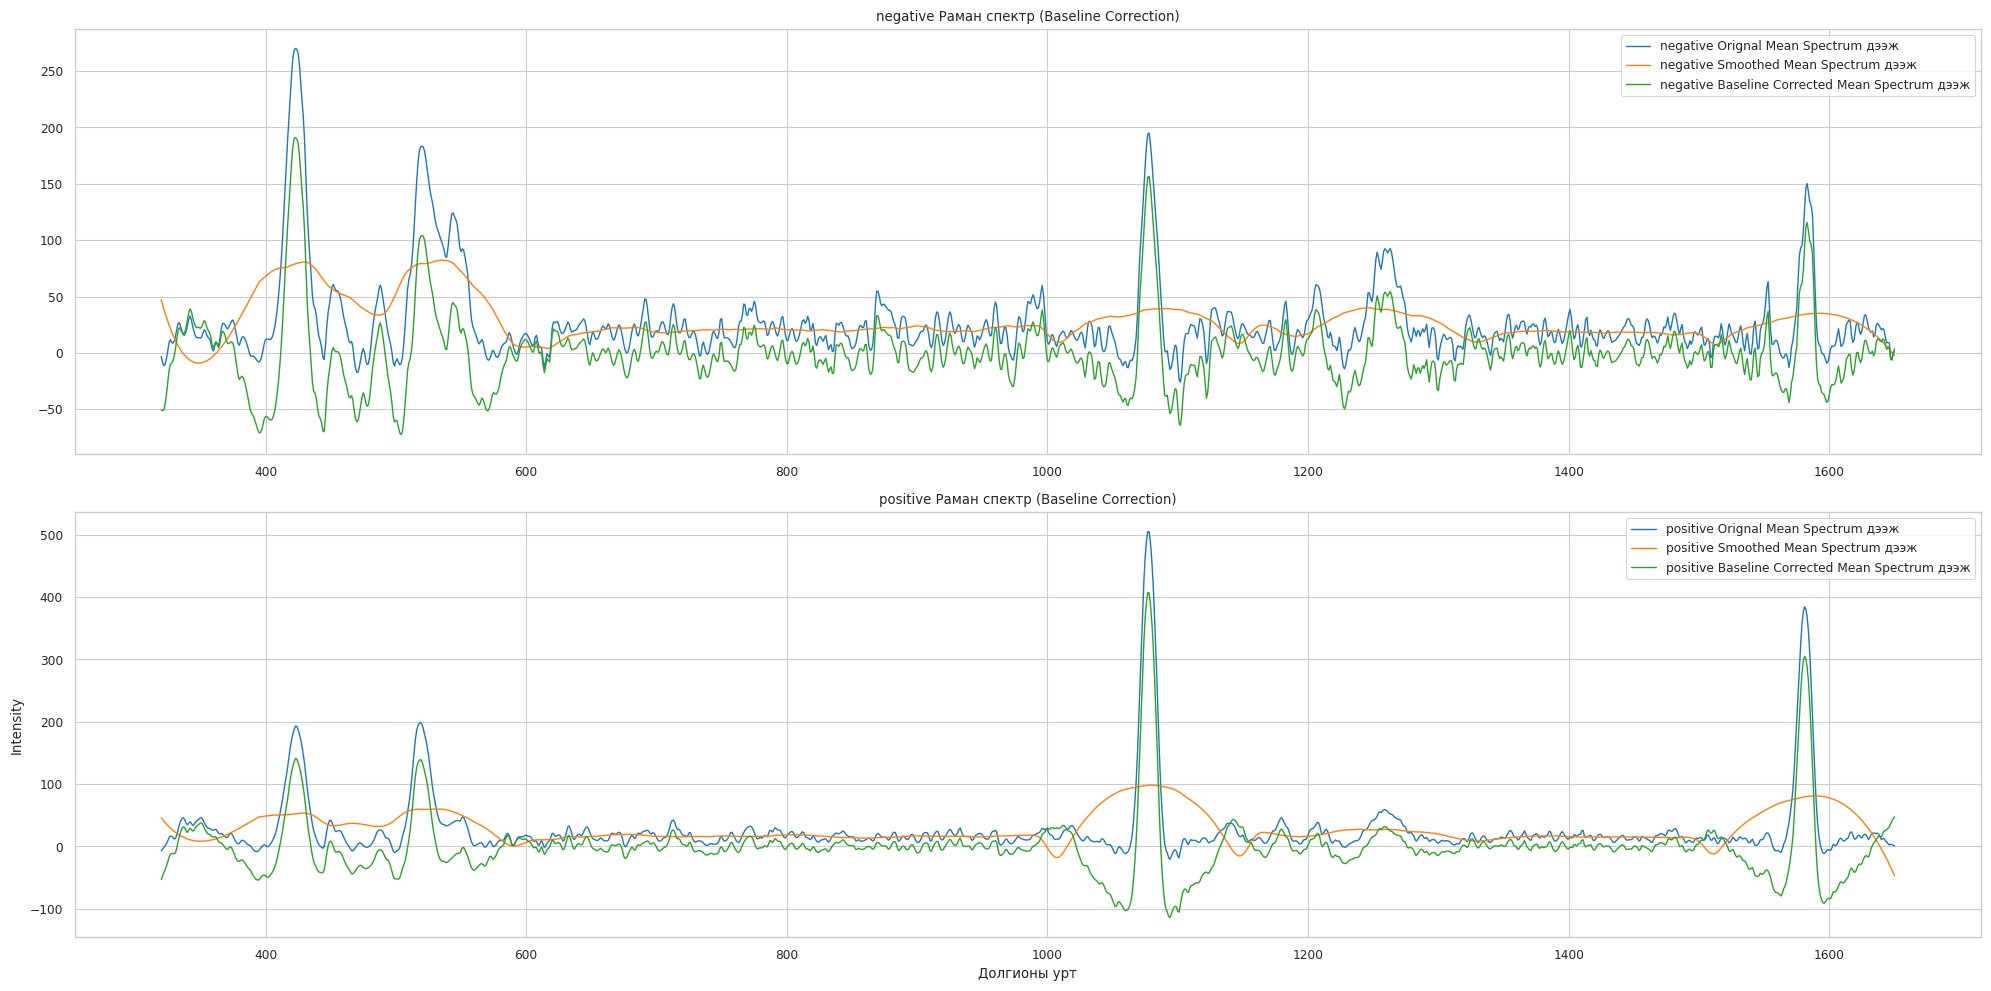

In [81]:
fig, axs = plt.subplots(len(binary_mean_spectrum), 1, figsize=(20, 10))

peak_color = ['r.', 'b.']

for i in range(len(binary_mean_spectrum)):
    tmp_intensity = mean_intensity[i]
    smoothed_mean_spectrum = savgol_filter(tmp_intensity, window_length=151, polyorder=3)
    baseline_corrected_mean_spectrum = tmp_intensity - smoothed_mean_spectrum

    axs[i].plot(wavelength, tmp_intensity, label=f'{y_mean[i]} Orignal Mean Spectrum дээж')
    axs[i].plot(wavelength, smoothed_mean_spectrum, label=f'{y_mean[i]} Smoothed Mean Spectrum дээж')
    axs[i].plot(wavelength, baseline_corrected_mean_spectrum, label=f'{y_mean[i]} Baseline Corrected Mean Spectrum дээж')
    
    axs[i].set_title('{} Раман спектр (Baseline Correction)'.format(y_mean[i]))
    axs[i].legend()
    axs[i].grid(True)

axs[1].set_ylabel('Intensity')
axs[1].set_xlabel('Долгионы урт')
# ax.set_xticks(custom_xticks)
plt.tight_layout()
plt.show()

In [79]:
def baseline_polynomial_savgol(spectrum, window_length=150, poly_order=3):
    baseline = savgol_filter(spectrum, window_length, poly_order)
    corrected_spectrum = spectrum - baseline
    return corrected_spectrum

corrected_spectrum_poly_savgol = baseline_polynomial_savgol(X.iloc[0])

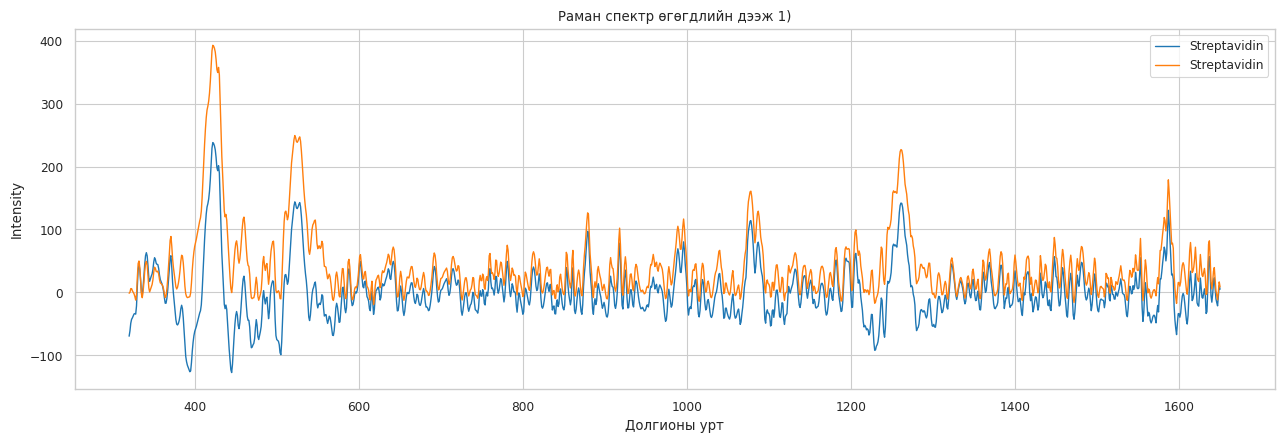

In [80]:
fig, ax = plt.subplots()

sns.lineplot(x=wavelength, y=corrected_spectrum_poly_savgol, ax=ax, label=f'{y_diagnostic[0]}')
ax.set_title("Раман спектр өгөгдлийн дээж 1 (Baseline Correction)")
ax.set_ylabel('Intensity')

sns.lineplot(x=wavelength, y=X.iloc[0], ax=ax, label=f'{y_diagnostic[0]}')
ax.set_title("Раман спектр өгөгдлийн дээж 1)")
ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.legend()

plt.show()

In [48]:
def baseline_correction_polynomial(spectrum, degree=3):
    x = np.arange(len(spectrum))
    baseline = np.polyfit(x, spectrum, degree)
    corrected_spectrum = spectrum - np.polyval(baseline, x)
    return corrected_spectrum

spectrum = X.iloc[0]
corrected_spectrum_poly = baseline_correction_polynomial(spectrum)

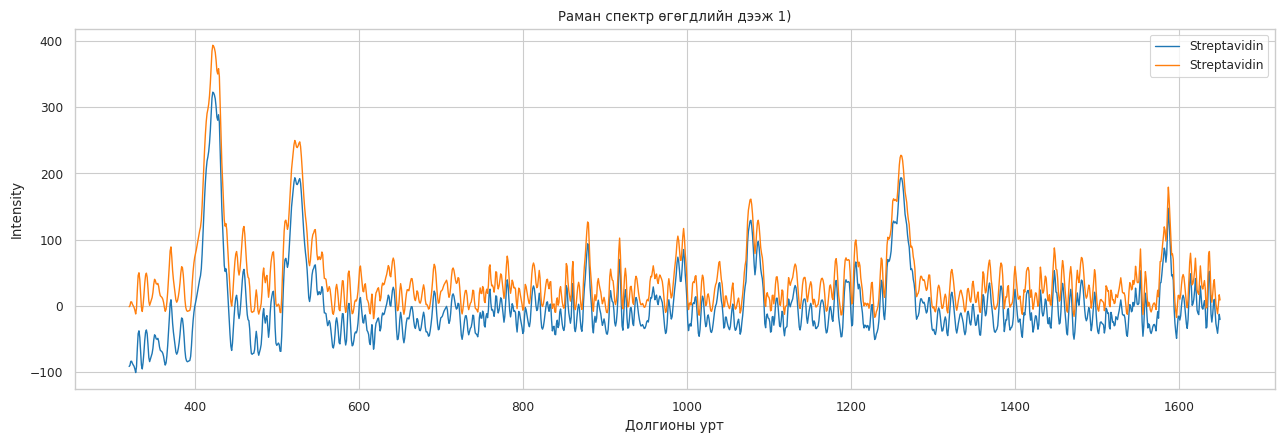

In [57]:
fig, ax = plt.subplots()

sns.lineplot(x=wavelength, y=corrected_spectrum_poly, ax=ax, label=f'{y_diagnostic[0]}')
ax.set_title("Раман спектр өгөгдлийн дээж 1 (Baseline Correction)")
ax.set_ylabel('Intensity')

sns.lineplot(x=wavelength, y=X.iloc[0], ax=ax, label=f'{y_diagnostic[0]}')
ax.set_title("Раман спектр өгөгдлийн дээж 1)")
ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.legend()

plt.show()

In [58]:
from scipy.ndimage import uniform_filter1d

def baseline_correction_rolling_ball(spectrum, window_size=50):
    baseline = uniform_filter1d(spectrum, size=window_size)
    corrected_spectrum = spectrum - baseline
    return corrected_spectrum

spectrum = X.iloc[0]
corrected_spectrum_rolling_ball = baseline_correction_rolling_ball(spectrum)

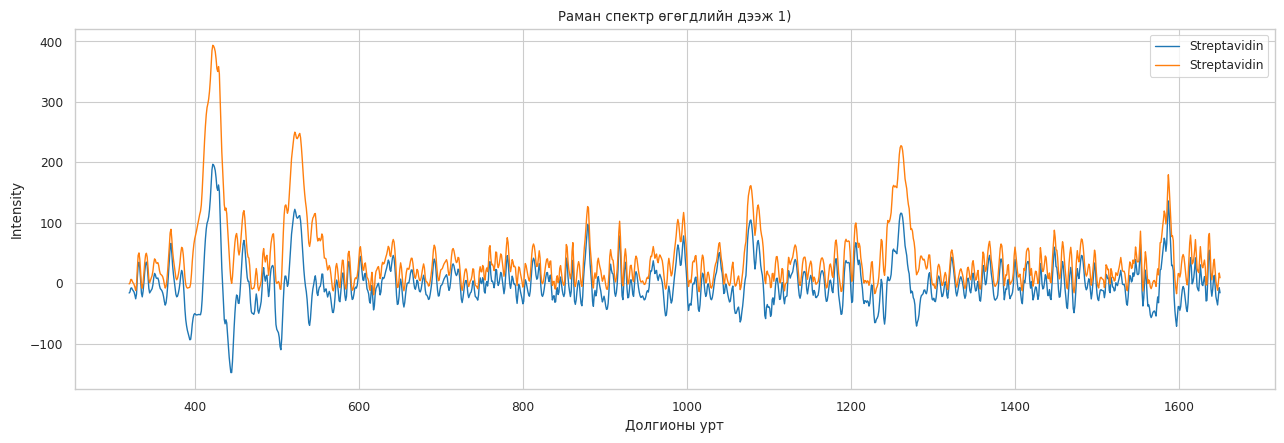

In [59]:
fig, ax = plt.subplots()

sns.lineplot(x=wavelength, y=corrected_spectrum_rolling_ball, ax=ax, label=f'{y_diagnostic[0]}')
ax.set_title("Раман спектр өгөгдлийн дээж 1 (Baseline Correction)")
ax.set_ylabel('Intensity')

sns.lineplot(x=wavelength, y=X.iloc[0], ax=ax, label=f'{y_diagnostic[0]}')
ax.set_title("Раман спектр өгөгдлийн дээж 1)")
ax.set_xlabel('Долгионы урт')
ax.set_ylabel('Intensity')
ax.legend()

plt.show()

### Zoom in

#### Binary Mean Spectrum seperate display

In [ ]:
intervals = [(400, 600), (1000, 1100), (1500, 1650)]  # Define the intervals as (start, end) pairs

fig, axs = plt.subplots(len(binary_mean_spectrum), len(intervals), figsize=(15, 8))

for row in range(len(binary_mean_spectrum)):
    for col, (start, end) in enumerate(intervals):
        # Set x-axis limits for the current interval
        axs[row, col].set_xlim(start, end)
        
        # Set tick positions and labels for the current interval
        tick_positions = np.arange(start, end + 1, step=20)
        axs[row, col].set_xticks(tick_positions)
        
        axs[row, col].set_xlabel('Wavelength')
        axs[row, col].set_ylabel('Intensity')
        axs[row, col].set_title(f'Zoomed In Interval: {start}-{end}')

        axs[row, col].plot(wavelength, mean_intensity[row], color=custom_colors[row], label='{}'.format(y_mean[row]))
        axs[row, col].legend()

plt.tight_layout()
plt.show()

#### One plot

In [ ]:
intervals = [(400, 600), (1000, 1100), (1500, 1650)]  # Define the intervals as (start, end) pairs

fig, axs = plt.subplots(1, len(intervals), sharey=True)

for i, (start, end) in enumerate(intervals):
    # Set x-axis limits for the current interval
    axs[i].set_xlim(start, end)
    
    # Set tick positions and labels for the current interval
    tick_positions = np.arange(start, end + 1, step=20)
    axs[i].set_xticks(tick_positions)

    axs[i].set_title(f'Zoomed In Interval: {start}-{end}')

    for j in range(len(binary_mean_spectrum)):
        axs[i].plot(wavelength, mean_intensity[j], label='{}'.format(y_mean[j]))
    
    axs[i].legend()
    axs[i].grid(True) 

axs[0].set_ylabel('Intensity')
axs[1].set_xlabel('Wavelength')

plt.tight_layout()
plt.show()

#### Multi class one plot

In [ ]:
intervals = [(400, 600), (1000, 1100), (1500, 1650)]  # Define the intervals as (start, end) pairs

fig, axs = plt.subplots(1, len(intervals), sharey=True)

for i, (start, end) in enumerate(intervals):
    # Set x-axis limits for the current interval
    axs[i].set_xlim(start, end)
    
    # Set tick positions and labels for the current interval
    tick_positions = np.arange(start, end + 1, step=20)
    axs[i].set_xticks(tick_positions)

    axs[i].set_title(f'Zoomed In Interval: {start}-{end}')

    for j in range(len(multiclass_mean_spectrum)):
        axs[i].plot(wavelength, avg_intensity[j], label='{}'.format(y_avg[j]))
    
    axs[i].legend()
    axs[i].grid(True) 

axs[0].set_ylabel('Intensity')
axs[1].set_xlabel('Wavelength')
plt.tight_layout()
plt.show()

## Model training

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_covid_status, stratify=y_covid_status, test_size=0.2, random_state=42)

In [8]:
y_train.value_counts(), y_test.value_counts()

(positive    23
 negative     5
 Name: COVID-19_Status, dtype: int64,
 positive    6
 negative    1
 Name: COVID-19_Status, dtype: int64)

In [9]:
# Encode the binary labels to numerical values (1 for 'positive', 0 for 'negative')
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

### Binary Clasification

#### Simple NN (Neural Network) model

In [130]:
model = Sequential([
    Dense(128, input_dim= X_train.shape[1], activation='relu'),
    Dense(1, activation='sigmoid')
])

In [131]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [132]:
history = model.fit(X_train, y_train_encoded, epochs=5, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Test loss: {loss:.2f}, Test accuracy: {accuracy*100:.2f}%')

Epoch 1/5
1/1 [==============================] - 0s 256ms/step - loss: 14.7789 - accuracy: 0.4643
Epoch 2/5
1/1 [==============================] - 0s 3ms/step - loss: 41.0118 - accuracy: 0.8214
Epoch 3/5
1/1 [==============================] - 0s 2ms/step - loss: 44.5282 - accuracy: 0.8214
Epoch 4/5
1/1 [==============================] - 0s 2ms/step - loss: 36.1829 - accuracy: 0.8214
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 21.8122 - accuracy: 0.8571
Test loss: 15.42, Test accuracy: 85.71%


##### Plotting

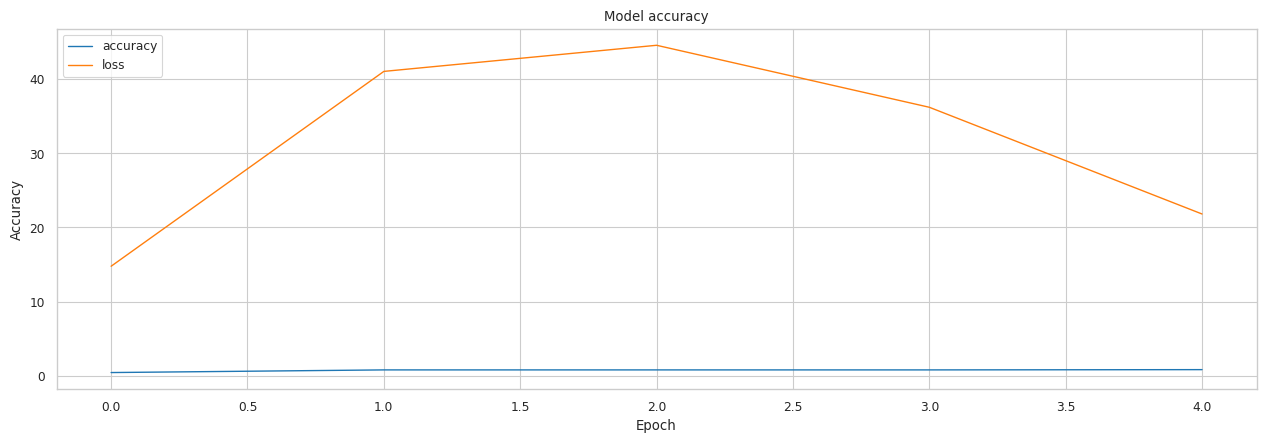

In [133]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

#### CNN (Convoulution Neural Network) model

Дараах давхаргуудтай манай машин сургалтын загвар маань:
1. kernel size 3x3-тай 32 шүүлтүүртэй 1D Convolution layer
2. Хэмжээс бууруулах зорилгоор MaxPooling1D давхаргыг ашиглаж байгаа үүнийг 2 stride тайгаар сонгосон.
3. Flatten буюу нэг цуваа вектор болгож хувиргана
4. Dense буюу бүрэн холбогдсон layer activation function аар ReLU
5. 2 ангилалд буулгахын тулд sigmoid activation function ашиглана

In [21]:
model = Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded), verbose=0)

Epoch 1/10
1/1 [==============================] - 0s 462ms/step - loss: 0.6486 - accuracy: 0.8214 - val_loss: 55.8507 - val_accuracy: 0.8571
Epoch 2/10
1/1 [==============================] - 0s 28ms/step - loss: 76.6487 - accuracy: 0.8214 - val_loss: 36.2177 - val_accuracy: 0.8571
Epoch 3/10
1/1 [==============================] - 0s 28ms/step - loss: 46.0901 - accuracy: 0.8214 - val_loss: 9.0226 - val_accuracy: 0.8571
Epoch 4/10
1/1 [==============================] - 0s 31ms/step - loss: 5.6581 - accuracy: 0.8571 - val_loss: 46.8022 - val_accuracy: 0.1429
Epoch 5/10
1/1 [==============================] - 0s 29ms/step - loss: 42.9094 - accuracy: 0.1786 - val_loss: 9.6058 - val_accuracy: 0.5714
Epoch 6/10
1/1 [==============================] - 0s 25ms/step - loss: 5.5873 - accuracy: 0.7143 - val_loss: 0.8032 - val_accuracy: 0.8571
Epoch 7/10
1/1 [==============================] - 0s 29ms/step - loss: 4.0598e-16 - accuracy: 1.0000 - val_loss: 9.7826 - val_accuracy: 0.8571
Epoch 8/10
1/1 [

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 0.8571428656578064


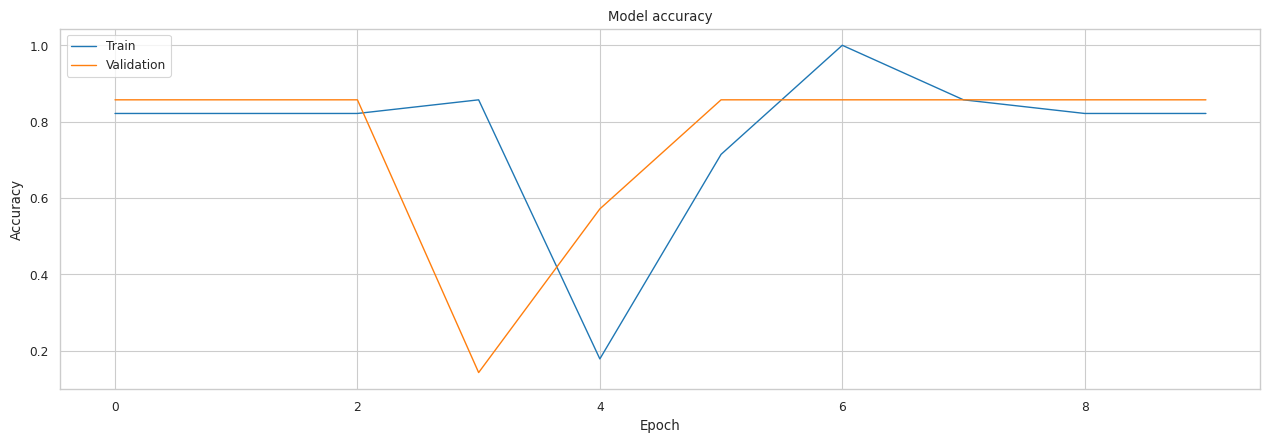

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### CNN model for Multi-Class

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_covid_status, stratify=y_covid_status, test_size=0.2, random_state=42)

In [36]:
spectra_length = X_train.shape[1]
X_train = X_train.reshape(-1, spectra_length, 1)
X_test = X_test.reshape(-1, spectra_length, 1)

In [31]:
model = Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(spectra_length, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_accuracy}')

Plot training & validation accuracy values

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### ResNET Model

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# Reshape the input data for ResNet (assuming each spectrum has a length of 'spectra_length')
spectra_length = X_train.shape[1]
X_train = X_train.reshape(-1, spectra_length, 1, 1)
X_test = X_test.reshape(-1, spectra_length, 1, 1)

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test_encoded, num_classes=5)

In [ ]:
# Step 2: Define the ResNet Model
def resnet_block(x, filters, kernel_size=3, activation='relu'):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # Second convolution layer
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add the shortcut to the output
    x = layers.add([x, shortcut])
    x = layers.Activation(activation)(x)

    return x

input_layer = layers.Input(shape=(spectra_length, 1))
x = input_layer

# Initial Convolution
x = layers.Conv1D(64, 7, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Residual Blocks (You can add more if needed)
x = resnet_block(x, 64)
x = resnet_block(x, 64)

# Global Average Pooling
x = layers.GlobalAveragePooling1D()(x)

# Output Layer
output_layer = layers.Dense(1, activation='sigmoid')(x)  # 2 output neurons for binary classification

# Create the ResNet model
model = models.Model(inputs=input_layer, outputs=output_layer)

# -->
# # Step 3: Compile the Model (Similar to the previous example)
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',  # Use categorical cross-entropy for binary classification
#               metrics=['accuracy'])

# Compile the Model (Using binary cross-entropy and the sigmoid activation function)
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy for binary classification
              metrics=['accuracy'])


# Step 4: Train the Model (Similar to the previous example)
num_epochs = 10  # Adjust as needed
batch_size = 32  # Adjust as needed
history = model.fit(X_train, y_train_encoded, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

# # Step 5: Evaluate the Model (Similar to the previous example)
# test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
# print(f'Test Accuracy: {test_accuracy}')

# Step 5: Evaluate the Model (using binary cross-entropy)
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


# Optionally, you can visualize training history (Similar to the previous example)


#### CNN model

In [ ]:
def weighted_loss(alpha, num_classes):
    def loss(y_true, y_pred):
        # Calculate the one-hot encoding of true labels
        true_labels = tf.one_hot(tf.argmax(y_true, axis=-1), depth=num_classes)

        # Calculate the weighted cross-entropy loss
        weighted_loss = -tf.reduce_mean(
            tf.reduce_sum(alpha * true_labels * tf.math.log(y_pred), axis=-1)
        )
        return weighted_loss
    return loss

In [ ]:
def weighted_loss(y_true, y_pred, alpha):
    # Calculate the negative log-likelihood loss for each sample and class
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    
    # Apply class-specific weights based on alpha
    weighted_loss = alpha * loss
    
    # Average the loss over all samples
    return tf.reduce_mean(weighted_loss)

In [ ]:
# Create a sequential model
model = models.Sequential()

# First Layer
model.add(layers.Conv1D(16, 21, input_shape=(spectral_length, 1)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling1D(2))

# Second Layer
model.add(layers.Conv1D(32, 11))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.MaxPooling1D(2))

# Third Layer
model.add(layers.Conv1D(64, 5))
model.add(layers.BatchNormalization())
model add(layers.LeakyReLU())
model.add(layers.MaxPooling1D(2))

# Concatenate and Flatten
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(2048, activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#### GAN (Generative Adversial Network) model

In [ ]:
class Generator(Sequential):
    def __init__(self):
        super(Generator, self).__init__()

        self.add(Conv1D(128, 3, strides=2, padding='same', input_shape=(935,)))
        self.add(LeakyReLU(alpha=0.2))
        self.add(Conv1D(128, 3, strides=2, padding='same'))
        self.add(LeakyReLU(alpha=0.2))
        self.add(Flatten())
        self.add(Dense(935, activation='tanh'))

In [ ]:
class Discriminator(Sequential):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.add(Conv1D(128, 3, strides=2, padding='same', input_shape=(935,)))
        self.add(LeakyReLU(alpha=0.2))
        self.add(Conv1D(128, 3, strides=2, padding='same'))
        self.add(LeakyReLU(alpha=0.2))
        self.add(Flatten())
        self.add(Dense(1, activation='sigmoid'))